In [1]:
!pip install pandas scikit-learn joblib


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import joblib
import os
from sklearn.ensemble import IsolationForest


# Define the path to the Google Drive folder and the historical CSV

historical_csv_path = "/content/historical_prices.csv"

# Load data from the historical CSV file
if not os.path.exists(historical_csv_path):
    raise FileNotFoundError(f"Historical data file not found at: {historical_csv_path}")

print(f"Loading data from the historical CSV file: {historical_csv_path}")
df = pd.read_csv(historical_csv_path)


# --- Data Cleaning and Preparation ---

# Ensure numeric columns exist and handle potential NaNs
numeric_cols_to_clean = ["price_numeric", "price_per_sqft", "bhk", "bathroom", "balcony"]
for col in numeric_cols_to_clean:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    else:
        # If a numeric column is missing, create it with NaNs or a default value if appropriate
        df[col] = np.nan # Or pd.Series(dtype=float)

# Balcony: fill blanks with 0 after converting to numeric
if "balcony" in df.columns:
    df["balcony"] = df["balcony"].fillna(0)
    df["balcony"] = pd.to_numeric(df["balcony"], errors="coerce")
else:
     df["balcony"] = 0 # Add column with 0 if it doesn't exist

# Drop rows with missing critical columns for the model before outlier detection
# Using lowercase column names as in the historical CSV
df = df.dropna(subset=["suburb", "price_per_sqft", "bhk", "bathroom"]) # Removed floor, furnishing, transaction from mandatory dropna

# ✅ Reset index after dropping rows to ensure alignment for Isolation Forest
df = df.reset_index(drop=True)

# Derive a metric for BHK-to-price ratio (handle division by zero or missing BHK)
df['price_per_bhk'] = df.apply(
    lambda row: row['price_numeric'] / row['bhk'] if row['bhk'] > 0 and pd.notna(row['price_numeric']) else np.nan,
    axis=1
)

# Drop rows where price_per_bhk could not be calculated
df = df.dropna(subset=["price_per_bhk"])

# ✅ Reset index again after dropping rows with NaN price_per_bhk
df = df.reset_index(drop=True)


# --- Isolation Forest for Outlier Detection ---

# Features to use for outlier detection
# Using log transform on price metrics as Isolation Forest is sensitive to scale
# ✅ Ensure outlier_features is created *after* resetting index
outlier_features = df[["price_per_sqft", "price_per_bhk"]].copy()
outlier_features["price_per_sqft"] = np.log1p(outlier_features["price_per_sqft"])
outlier_features["price_per_bhk"] = np.log1p(outlier_features["price_per_bhk"])

# Initialize and train Isolation Forest model
# contamination='auto' lets the algorithm decide, or you can set a value between 0 and 0.5
iso_forest = IsolationForest(contamination='auto', random_state=42)
# ✅ Fit on the features DataFrame directly, which now has a contiguous index
outlier_predictions = iso_forest.fit_predict(outlier_features)

# Filter out outliers (Isolation Forest predicts -1 for outliers and 1 for inliers)
# ✅ Filter df directly using the predictions array which is aligned after index resets
df_cleaned = df[outlier_predictions == 1].copy()

print(f"Original number of records: {len(df)}")
print(f"Number of records after outlier removal: {len(df_cleaned)}")

# Use the cleaned dataframe for model training
df = df_cleaned

# Cap extreme outliers (remove top 1%) - Redundant after Isolation Forest, but keeping for safety if needed
# df = df[df["price_per_sqft"].notna() & (df["price_per_sqft"] > 0)]
# if not df["price_per_sqft"].empty:
#   df = df[df["price_per_sqft"] < df["price_per_sqft"].quantile(0.99)]


# Features & target
# Using lowercase column names as in the historical CSV
cat_features = ["suburb"]
# Add other categorical features if they exist in the dataframe after loading
optional_cat_features = ["floor", "furnishing", "transaction"]
for feature in optional_cat_features:
    if feature in df.columns:
        # Fill NaNs in categorical features with a placeholder like 'Unknown' before one-hot encoding
        df[feature] = df[feature].fillna('Unknown')
        cat_features.append(feature)
    else:
        # If a categorical feature is missing entirely, add it with 'Unknown'
        df[feature] = 'Unknown'
        cat_features.append(feature)


num_features = ["bhk", "bathroom", "balcony"]
# Ensure numeric features exist before selecting
num_features = [f for f in num_features if f in df.columns]


# Ensure all required features are in the DataFrame before selecting
required_features = num_features + cat_features
for feature in required_features:
    if feature not in df.columns:
        # This should ideally not happen with the adding missing columns logic above,
        # but as a safeguard:
         raise ValueError(f"Required feature '{feature}' not found in the DataFrame even after handling.")


X = df[required_features]
y = np.log1p(df["price_per_sqft"])  # log-transform target

# One-hot encode categorical variables
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
X_encoded = encoder.fit_transform(X[cat_features])
encoded_cols = encoder.get_feature_names_out(cat_features)
X_encoded_df = pd.DataFrame(X_encoded, columns=encoded_cols, index=X.index)

# Combine encoded + numeric features
X_final = pd.concat([X[num_features], X_encoded_df], axis=1)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42)

# Train model
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)
print("MSE (log scale):", mean_squared_error(y_test, y_pred))
print("MSE (original scale):", mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

# Save model and encoder
joblib.dump(model, "price_model.pkl")
joblib.dump(encoder, "encoder.pkl")

print("Model and encoder saved successfully!")

Loading data from the historical CSV file: /content/historical_prices.csv
Original number of records: 6314
Number of records after outlier removal: 4980
MSE (log scale): 0.049459483439747674
MSE (original scale): 24633494.858167745
Model and encoder saved successfully!


In [3]:
# Combine encoded + numeric features
X_final = pd.concat([X[["bhk", "bathroom", "balcony"]], X_encoded_df], axis=1)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42)

# Train model
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)
print("MSE (log scale):", mean_squared_error(y_test, y_pred))
print("MSE (original scale):", mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

# Save model and encoder
joblib.dump(model, "price_model.pkl")
joblib.dump(encoder, "encoder.pkl")

print("Model and encoder saved successfully!")

MSE (log scale): 0.049459483439747674
MSE (original scale): 24633494.858167745
Model and encoder saved successfully!


In [4]:
print(df["price_per_sqft"].describe())

count     4980.000000
mean     23014.356024
std       8247.650125
min       5167.000000
25%      17194.750000
50%      21925.000000
75%      28119.000000
max      48622.000000
Name: price_per_sqft, dtype: float64


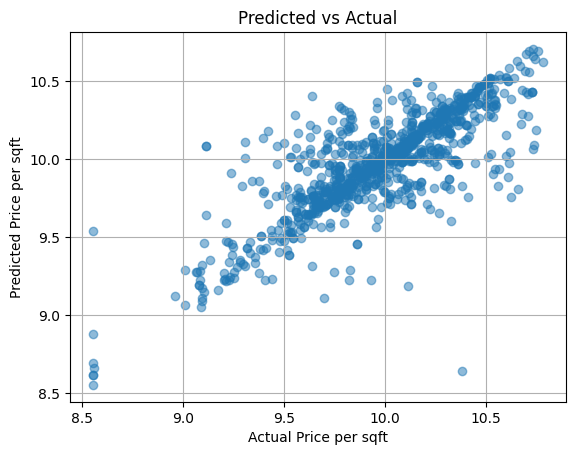

In [5]:
import matplotlib.pyplot as plt

plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("Actual Price per sqft")
plt.ylabel("Predicted Price per sqft")
plt.title("Predicted vs Actual")
plt.grid(True)
plt.show()


In [6]:
# Check highest price per sqft values
print(df.sort_values("price_per_sqft", ascending=False).head(10))

                                                  title  \
3532         2 BHK Flat for Sale in Bandra East, Mumbai   
2286      2 BHK Apartment for Sale in Dadar West Mumbai   
5927  4 BHK Apartment for Sale in Bileshwar Darshan ...   
4983  3 BHK Apartment for Sale in Lodha Park, Worli ...   
4984  3 BHK Apartment for Sale in Lodha Park, Worli ...   
5574      3 BHK Flat  for Sale in  Linking Road, Mumbai   
4729  3 BHK Apartment for Sale in Aditya Runwal Eleg...   
5754  3 BHK Flat  for Sale in  Runwal Nirvana, Runwa...   
6191  4 BHK Flat  for Sale in  Trump Tower, Trump To...   
6190  4 BHK Flat  for Sale in  Trump Tower, Trump To...   

                    location price_raw  price_numeric      suburb  bhk  \
3532             Bandra East      3 Cr       30000000      Bandra  2.0   
2286       Dadar West Mumbai   3.40 Cr       34000000       Dadar  2.0   
5927  Vile Parle East Mumbai   6.55 Cr       65500000  Vile Parle  4.0   
4983            Worli Mumbai      7 Cr       70000000 

In [7]:
#remove potential outliers
df = df[df["price_per_sqft"] < 100000]

In [8]:
print(df["price_per_sqft"].dtype)
print(df["price_per_sqft"].head(10))

float64
0     40685.0
1     40685.0
2     16842.0
5     16201.0
6     26667.0
9     14789.0
10    19429.0
11    21538.0
12    20755.0
13    20755.0
Name: price_per_sqft, dtype: float64


In [9]:
# LET'S PREDICT!
# Sample new input (you can change these values to test)
new_data = pd.DataFrame({
    "bhk": [2],
    "bathroom": [2],
    "balcony": [0],
    "suburb": ["Bandra"],
    "floor": ["Middle Floor"],
    "furnishing": ["Semi-Furnished"],
    "transaction": ["Resale"]
})

# Define the same feature lists used during training
cat_features = ["suburb", "floor", "furnishing", "transaction"]
num_features = ["bhk", "bathroom", "balcony"]

# Encode categorical features
encoded = encoder.transform(new_data[cat_features])
encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(cat_features))
encoded_df.index = new_data.index

# Combine numeric and encoded features
final_input = pd.concat([new_data[num_features].reset_index(drop=True), encoded_df.reset_index(drop=True)], axis=1)

# Predict
log_price_pred = model.predict(final_input)[0]
actual_price = np.expm1(log_price_pred)

print("Predicted Price per sqft:", round(actual_price, 2))

Predicted Price per sqft: 32850.03


In [10]:
df.to_csv("property_data.csv", index=False)


In [11]:
import pandas as pd
import os

# Define the path to the Google Drive folder and the historical CSV

historical_csv_path = "/content/historical_prices.csv"

# Load data from the historical CSV file
if not os.path.exists(historical_csv_path):
    raise FileNotFoundError(f"Historical data file not found at: {historical_csv_path}")

df = pd.read_csv(historical_csv_path)

# Filter out properties from the 'Other' suburb as they lack specific location data for geocoding
df = df[df['suburb'] != 'Other'].copy()

# Display the first few rows and info
print("DataFrame Head after filtering 'Other' suburb:")
display(df.head())

print("\nDataFrame Info after filtering 'Other' suburb:")
df.info()

DataFrame Head after filtering 'Other' suburb:


,title,location,price_raw,price_numeric,suburb,bhk,price_per_sqft,description,scraped_at,carpet-area,...,balcony,super-area,dimensions,plot-area,open-sides,width-road-facing,boundary,source_file,date_scraped,property_id
2,1 BHK Apartment for Sale in A&O Realty Excelle...,Siddharth Nagar Mulund West Mumbai,80 Lac,8000000,Mulund,1.0,16842.0,The availability was verified on 2025-12-10 ....,2026-01-27 17:49:04,312 sqft,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,properties_2026-01-27.json,2026-01-27,1_bhk_apartment_for_sale_in_a&o_realty_excelle...
5,"1 BHK Apartment for Sale in Aadi Allure, Kanju...",Kanjurmarg East Mumbai,1.25 Cr,12500000,Kanjurmarg,1.0,16201.0,The availability was verified on 2026-01-23 ....,2026-02-01 15:16:55,484 sqft,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,properties_2026-02-01.json,2026-02-01,"1_bhk_apartment_for_sale_in_aadi_allure,_kanju..."
6,"1 BHK Apartment for Sale in Aakruti Atria, And...",Andheri East Mumbai,60 Lac,6000000,Andheri,1.0,26667.0,View Property Nearby Solitaire Corporate Pa...,2025-11-12 16:14:11,162 sqft,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,properties_2025-11-12.json,2025-11-12,"1_bhk_apartment_for_sale_in_aakruti_atria,_and..."
9,"1 BHK Apartment for Sale in Aawej Heights, And...",Andheri West Mumbai,1.05 Cr,10500000,Andheri,1.0,14789.0,This Multistorey Apartment is located at 4th f...,2026-02-01 15:16:57,NaN,...,1.0,710 sqft,NaN,NaN,NaN,NaN,NaN,properties_2026-02-01.json,2026-02-01,"1_bhk_apartment_for_sale_in_aawej_heights,_and..."
10,"1 BHK Apartment for Sale in Adinath Avenue, Ad...",Adarsh Nagar Malad West Mumbai,1.02 Cr,10200000,Malad,1.0,19429.0,The availability was verified on 2026-01-25 ....,2026-01-27 17:48:51,378 sqft,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,properties_2026-01-27.json,2026-01-27,"1_bhk_apartment_for_sale_in_adinath_avenue,_ad..."



DataFrame Info after filtering 'Other' suburb:
<class 'pandas.core.frame.DataFrame'>
Index: 5241 entries, 2 to 7397
Data columns (total 30 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   title              5241 non-null   object 
 1   location           5241 non-null   object 
 2   price_raw          5241 non-null   object 
 3   price_numeric      5241 non-null   int64  
 4   suburb             5241 non-null   object 
 5   bhk                4964 non-null   float64
 6   price_per_sqft     4891 non-null   float64
 7   description        5201 non-null   object 
 8   scraped_at         5241 non-null   object 
 9   carpet-area        4272 non-null   object 
 10  status             4987 non-null   object 
 11  floor              4998 non-null   object 
 12  transaction        5240 non-null   object 
 13  furnishing         4972 non-null   object 
 14  facing             2545 non-null   object 
 15  overlooking        2416 non-n

In [12]:
from geopy.geocoders import Nominatim
import time

# Initialize Nominatim geocoder
geolocator = Nominatim(user_agent="geo_heatmap_app")

# Get unique suburbs from the DataFrame
unique_suburbs = df["suburb"].unique()

# Dictionary to store suburb coordinates
suburb_coords = {}

# Geocode each unique suburb
for suburb in unique_suburbs:
    try:
        # Attempt to geocode the suburb, specifying Mumbai, India for better accuracy
        location = geolocator.geocode(f"{suburb}, Mumbai, India")
        if location:
            suburb_coords[suburb] = {"latitude": location.latitude, "longitude": location.longitude}
            print(f"Geocoded '{suburb}': {location.latitude}, {location.longitude}")
        else:
            suburb_coords[suburb] = {"latitude": None, "longitude": None}
            print(f"Could not geocode '{suburb}'")
    except Exception as e:
        suburb_coords[suburb] = {"latitude": None, "longitude": None}
        print(f"Error geocoding '{suburb}': {e}")
    # Add a small delay to avoid overwhelming the geocoding service
    time.sleep(1)

# Display the obtained coordinates
print("\nSuburb Coordinates:")
for suburb, coords in suburb_coords.items():
    print(f"{suburb}: {coords}")

Geocoded 'Mulund': 19.1721762, 72.9562383
Geocoded 'Kanjurmarg': 19.124102, 72.9385562
Geocoded 'Andheri': 19.1196976, 72.8464205
Geocoded 'Malad': 19.1867193, 72.8485884
Geocoded 'Borivali': 19.229068, 72.8573628
Geocoded 'Virar': 19.5063691, 72.8434536
Geocoded 'Mazgaon': 18.9697337, 72.8406201
Geocoded 'Wadala': 19.0269192, 72.8759337
Geocoded 'Bhandup': 19.1438684, 72.9384327
Geocoded 'Mira Road': 19.1878962, 72.8365955
Geocoded 'Kandivali': 19.2041136, 72.8517376
Geocoded 'Ghatkopar': 19.0856928, 72.9083668
Geocoded 'Vile Parle': 19.0999098, 72.8440038
Geocoded 'Chunabhatti': 19.0520886, 72.8674141
Geocoded 'Bandra': 19.0549792, 72.8402203
Geocoded 'Sion': 19.0465213, 72.8632834
Geocoded 'Goregaon': 19.1648688, 72.8495492
Geocoded 'Chembur': 19.054818, 72.8979713
Geocoded 'Khar': 19.0682411, 72.8400412
Geocoded 'Bhayandar': 19.2813147, 72.8747815
Geocoded 'Dadar': 19.0192269, 72.8428479
Geocoded 'Mahim': 19.0423145, 72.8398344
Geocoded 'Byculla': 18.9766219, 72.8327936
Geocoded 'K

In [13]:
import numpy as np

# Ensure 'price_per_sqft' is numeric before aggregation
df['price_per_sqft'] = pd.to_numeric(df['price_per_sqft'], errors='coerce')

# Aggregate data by suburb
suburb_agg = df.groupby('suburb').agg(
    property_count=('title', 'size'),  # Count the number of properties
    average_price_per_sqft=('price_per_sqft', 'mean') # Calculate the mean price per sqft
).reset_index()

# Merge with suburb coordinates
# Convert suburb_coords dictionary to a DataFrame for merging
suburb_coords_df = pd.DataFrame.from_dict(suburb_coords, orient='index').reset_index()
suburb_coords_df.columns = ['suburb', 'latitude', 'longitude']

# Merge the aggregated data with coordinates
suburb_agg = pd.merge(suburb_agg, suburb_coords_df, on='suburb', how='left')

# Display the first few rows of the aggregated DataFrame
print("Aggregated Suburb Data with Coordinates:")
display(suburb_agg.head())

Aggregated Suburb Data with Coordinates:


,suburb,property_count,average_price_per_sqft,latitude,longitude
0,Andheri,608,27363.127208,19.119698,72.846420
1,Antop Hill,2,30229.000000,19.030181,72.866950
2,Bandra,138,39582.484848,19.054979,72.840220
3,Bhandup,204,18142.188776,19.143868,72.938433
4,Bhayandar,96,12257.411111,19.281315,72.874781


In [14]:
import folium

# Coordinates for the center of Mumbai
mumbai_coords = [19.0760, 72.8777]

# Create a Folium map object
m = folium.Map(location=mumbai_coords, zoom_start=11)

print("Folium map object created successfully.")

Folium map object created successfully.


In [15]:
from folium.plugins import HeatMap
import numpy as np

# 1. Remove any rows from the suburb_agg DataFrame where either 'latitude' or 'longitude' is NaN
suburb_agg_cleaned = suburb_agg.dropna(subset=['latitude', 'longitude']).copy()

# Ensure average_price_per_sqft is numeric and handle potential NaNs before plotting
suburb_agg_cleaned['average_price_per_sqft'] = pd.to_numeric(suburb_agg_cleaned['average_price_per_sqft'], errors='coerce').fillna(0)


# 2. Create a HeatMap layer for property density
# HeatMap requires a list of [latitude, longitude, intensity]
heat_data_density = [[row['latitude'], row['longitude'], row['property_count']] for index, row in suburb_agg_cleaned.iterrows()]

HeatMap(heat_data_density, radius=15).add_to(m) # Adjust radius as needed

# 3. Create a new layer for the average price per square foot visualization.
# Using CircleMarkers for average price per sqft
# The radius can represent property count, and color/tooltip can show average price
for index, row in suburb_agg_cleaned.iterrows():
    # Scale radius based on property count for better visibility
    radius = min(max(row['property_count'] / 10, 5), 20) # Scale property count to a reasonable radius range

    # Determine color based on average price (optional, for visual differentiation)
    # This is a simple example, you might use a colormap based on price ranges
    color = 'blue' if row['average_price_per_sqft'] < 20000 else ('green' if row['average_price_per_sqft'] < 40000 else 'red')

    # 4. Add tooltips
    tooltip_text = f"Suburb: {row['suburb']}<br>Properties: {row['property_count']}<br>Avg Price/SqFt: {row['average_price_per_sqft']:.2f}"

    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=radius,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.6,
        tooltip=tooltip_text
    ).add_to(m)


# Display the map (in Jupyter notebooks, this will render the map)
display(m)

In [16]:
!pip install osmnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.5/101.5 kB 2.5 MB/s eta 0:00:00


In [17]:
import osmnx as ox
import pandas as pd
import time
import os
import pandas as pd

if os.path.exists("/content/magicbricks_scraper/suburb_amenities_mumbai.csv"):
    # ✅ Load saved amenities (fast)
    print("📂 Loading existing suburb amenities...")
    amenity_df = pd.read_csv("suburb_amenities_mumbai.csv")
else:
    # ⚙️ Only run this if file doesn’t exist
    print("⚙️ Fetching amenities from OpenStreetMap (this may take time)...")


# List of amenities to extract
amenities = ['school', 'park', 'mall', 'hospital', 'club']

# Updated function for osmnx >= 1.9
def get_amenity_counts(lat, lon, radius=2000):
    """
    Fetch nearby amenities from OpenStreetMap using osmnx within a given radius (in meters).
    Returns a dictionary with counts for each amenity type.
    """
    if pd.isna(lat) or pd.isna(lon):
        return {a: 0 for a in amenities}

    tags = {'amenity': amenities}
    try:
        # ✅ Updated for new osmnx version
        gdf = ox.features_from_point((lat, lon), tags=tags, dist=radius)

        counts = {}
        for a in amenities:
            counts[a] = len(gdf[gdf['amenity'] == a]) if 'amenity' in gdf.columns else 0

        return counts
    except Exception as e:
        print(f"⚠️ Error fetching amenities for ({lat}, {lon}): {e}")
        return {a: 0 for a in amenities}

# Initialize list to store data
amenity_data = []

# Iterate over each suburb
for idx, row in suburb_agg.iterrows():
    lat, lon = row['latitude'], row['longitude']
    suburb_name = row['suburb']

    if pd.notna(lat) and pd.notna(lon):
        print(f"Fetching amenities for {suburb_name}...")
        counts = get_amenity_counts(lat, lon)
    else:
        counts = {a: 0 for a in amenities}
        print(f"Skipping {suburb_name} (no coordinates).")

    counts['suburb'] = suburb_name
    amenity_data.append(counts)

    # Delay to respect OSM server rate limits
    time.sleep(1)

# Convert to DataFrame
amenity_df = pd.DataFrame(amenity_data)

# Drop any existing amenity columns before merging to avoid duplicates
for a in ['school', 'park', 'mall', 'hospital', 'club']:
    if a in suburb_agg.columns:
        suburb_agg.drop(columns=[a], inplace=True)

# Merge with clean amenity data
suburb_agg = pd.merge(suburb_agg, amenity_df, on='suburb', how='left')

# Show clean final result
print("\n✅ Suburb-level Amenity Data (cleaned):")
display(suburb_agg.head())


⚙️ Fetching amenities from OpenStreetMap (this may take time)...
Fetching amenities for Andheri...
Fetching amenities for Antop Hill...
Fetching amenities for Bandra...
Fetching amenities for Bhandup...
Fetching amenities for Bhayandar...
Fetching amenities for Borivali...
Fetching amenities for Byculla...
Fetching amenities for Charkop...
Fetching amenities for Charni Road...
Fetching amenities for Chembur...
Fetching amenities for Chunabhatti...
Fetching amenities for Dadar...
Fetching amenities for Dahisar...
Fetching amenities for Ghatkopar...
Fetching amenities for Goregaon...
Fetching amenities for Govandi...
Fetching amenities for Juhu...
Fetching amenities for Kandivali...
Fetching amenities for Kanjurmarg...
Fetching amenities for Khar...
Fetching amenities for Kurla...
Fetching amenities for Madh...
Fetching amenities for Mahim...
Fetching amenities for Malad...
Fetching amenities for Matunga...
Fetching amenities for Mazgaon...
Fetching amenities for Mira Road...
Fetching am

,suburb,property_count,average_price_per_sqft,latitude,longitude,school,park,mall,hospital,club
0,Andheri,608,27363.127208,19.119698,72.846420,35,0,0,68,0
1,Antop Hill,2,30229.000000,19.030181,72.866950,45,3,0,33,0
2,Bandra,138,39582.484848,19.054979,72.840220,45,3,0,44,0
3,Bhandup,204,18142.188776,19.143868,72.938433,15,0,0,28,0
4,Bhayandar,96,12257.411111,19.281315,72.874781,9,0,0,28,0


In [18]:
# Save once after generating amenities
amenity_df.to_csv("suburb_amenities_mumbai.csv", index=False)
print("✅ Saved suburb amenities to 'suburb_amenities_mumbai.csv'")


✅ Saved suburb amenities to 'suburb_amenities_mumbai.csv'


In [19]:
pip install xgboost lightgbm scikit-learn


In [20]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
import lightgbm as lgb


In [21]:
# Avoid division by zero — use 1 / (count + 1) as a pseudo "distance"
for amenity in ['school', 'park', 'mall', 'hospital']:
    df = pd.merge(df, suburb_agg[['suburb', amenity]], on='suburb', how='left')
    df[f'{amenity}_density'] = 1 / (df[amenity] + 1)
    df.drop(columns=[amenity], inplace=True)


In [22]:
if 'season' in df.columns:
    suburb_trend = df.groupby(['suburb', 'season'])['price_per_sqft'].mean().groupby('suburb').shift(1)
    df['historical_price'] = suburb_trend.fillna(df.groupby('suburb')['price_per_sqft'].transform('mean'))
else:
    # If single period — use suburb-level average
    df['historical_price'] = df.groupby('suburb')['price_per_sqft'].transform('mean')


In [23]:
# Select numerical + engineered features
# Excluding 'floor' as requested
feature_cols = [
    'bhk', 'bathroom', 'balcony',
    'school_density', 'park_density', 'mall_density', 'hospital_density',
    'historical_price'
]

# Separate features and target
X = df[feature_cols].copy() # Create a copy to avoid SettingWithCopyWarning
y = df['price_per_sqft']

# Drop rows with missing target values before splitting
combined = X.copy()
combined['price_per_sqft'] = y
combined.dropna(subset=['price_per_sqft'], inplace=True) # Drop rows with missing price_per_sqft
X = combined[feature_cols]
y = combined['price_per_sqft']


# Define categorical and numerical features
# No categorical features remaining after removing 'floor'
cat_features = [] # Empty list as 'floor' is removed
num_features = [
    'bhk', 'bathroom', 'balcony',
    'school_density', 'park_density', 'mall_density', 'hospital_density',
    'historical_price'
]

# Impute missing values in numerical features using the mean *after* dropping NaNs in target
for col in num_features:
    if col in X.columns:
        X[col] = X[col].fillna(X[col].mean())


# One-hot encode categorical variables (this will now do nothing as cat_features is empty)
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
X_encoded = encoder.fit_transform(X[cat_features])
encoded_cols = encoder.get_feature_names_out(cat_features)
X_encoded_df = pd.DataFrame(X_encoded, columns=encoded_cols, index=X.index)

# Combine encoded + numeric features
# Since cat_features is empty, X_final will be the same as X
X_final = pd.concat([X[num_features], X_encoded_df], axis=1)


# Split data
X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42)

/tmp/ipython-input-2303394465.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = X[col].fillna(X[col].mean())


Original dataset shape: (5241, 35)
Model dataset shape after dropping missing: (1306, 35)
✅ XGBoost Regression Results
RMSE: 6715.55
R²: 0.784


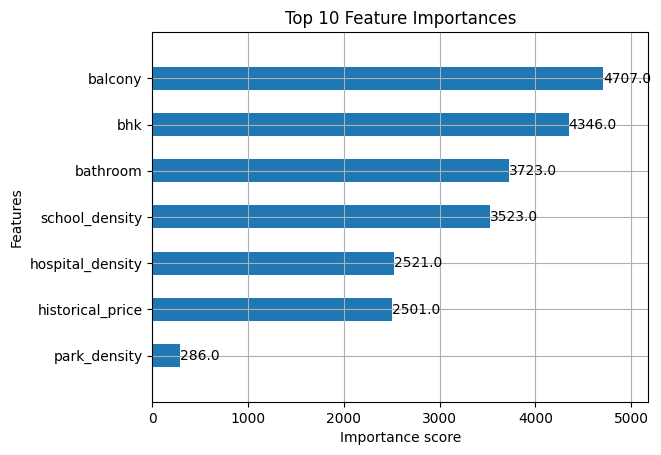

✅ Model saved as 'xgb_price_per_sqft_model.pkl'


In [24]:
# ------------------------------
# XGBoost Regression for Price per Sqft
# ------------------------------

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb

# 1️⃣ Prepare the dataset
# Use numeric columns including your enriched features
features = [
    "bhk",
    "bathroom",
    "balcony",
    "school_density",
    "park_density",
    "mall_density",
    "hospital_density",
    "historical_price"
]

target = "price_per_sqft"  # Make sure this column exists and is numeric

# Drop rows with missing target or features
model_df = df.dropna(subset=features + [target]).copy()

X = model_df[features]
y = model_df[target]

print(f"Original dataset shape: {df.shape}")
print(f"Model dataset shape after dropping missing: {model_df.shape}")

# 2️⃣ Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 3️⃣ Train XGBoost Regressor
model = xgb.XGBRegressor(
    n_estimators=500,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

model.fit(X_train, y_train)

# 4️⃣ Predictions
y_pred = model.predict(X_test)

# 5️⃣ Evaluate model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("✅ XGBoost Regression Results")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.3f}")

# 6️⃣ Feature importance
import matplotlib.pyplot as plt

xgb.plot_importance(model, max_num_features=10, importance_type='weight', height=0.5)
plt.title("Top 10 Feature Importances")
plt.show()

# 7️⃣ Save model (optional)
import joblib
joblib.dump(model, "xgb_price_per_sqft_model.pkl")
print("✅ Model saved as 'xgb_price_per_sqft_model.pkl'")


In [25]:
# Define a new property's features
# Ensure the column names match the features used during training
new_property_features = pd.DataFrame({
    "bhk": [2],
    "bathroom": [2],
    "balcony": [5],
    "school_density": [1 / (34 + 1)], # Example density based on average schools in Andheri
    "park_density": [1 / (0 + 1)],    # Example density based on average parks in Andheri
    "mall_density": [1 / (0 + 1)],    # Example density based on average malls in Andheri
    "hospital_density": [1 / (67 + 1)], # Example density based on average hospitals in Andheri
    "historical_price": [24663.11] # Example historical price based on average in Andheri
})

# Ensure the column order matches the training data if necessary (though XGBoost handles this)
# For robustness, explicitly select and reorder columns if needed, but not strictly required for XGBoost
# new_property_features = new_property_features[features] # 'features' list from previous cell

# Predict the price per square foot for the new property
predicted_price_per_sqft = model.predict(new_property_features)[0]

# Print the predicted price
print(f"Predicted Price per sqft for the new property: {predicted_price_per_sqft:.2f}")

Predicted Price per sqft for the new property: 26065.97


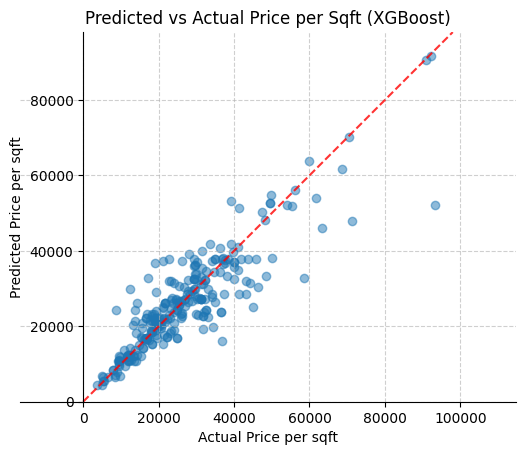

In [26]:
import matplotlib.pyplot as plt

# Create scatter plot
plt.scatter(y_test, y_pred, alpha=0.5)

# Set labels and title
plt.xlabel("Actual Price per sqft")
plt.ylabel("Predicted Price per sqft")
plt.title("Predicted vs Actual Price per Sqft (XGBoost)")

# Make axes equal scale
plt.axis('equal')

# Compute symmetric limits around the data range, starting from 0
min_val = min(min(y_test), min(y_pred))
max_val = max(max(y_test), max(y_pred))

# Ensure 0 is included and centered properly
lims = [0, max_val * 1.05]

plt.xlim(lims)
plt.ylim(lims)

# Draw diagonal y = x line
plt.plot(lims, lims, 'r--', alpha=0.8)

# Move spines (axes) to intersect at 0
ax = plt.gca()
ax.spines['left'].set_position('zero')
ax.spines['bottom'].set_position('zero')

# Hide the top and right spines
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')

# Add grid
plt.grid(True, linestyle='--', alpha=0.6)

plt.show()


In [27]:
df.to_csv("processed_properties.csv", index=False)


In [28]:
from google.colab import files
files.download("processed_properties.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [29]:
# Save suburb-level data
suburb_agg.to_csv("suburb_agg.csv", index=False)